# Task

Operators like joins, selections and missing value imputaters can cause *data distribution issues*, which can heavily impact the performance of our model for specific demographic groups. Mlinspect helps with identifying such issues by offering a check that calculates histograms for sensitive groups in the data and verifying whether the histogram change is significant enough to alert the user. Thanks to our annotation propagation, we can deal with complex code involving things like nested sklearn pipelines and group memberships that are removed from the training data using projections.

We want to find out if preprocessing operations in pipelines introduce bias and if so, which groups are effected.
The pipeline we want to analyse in this task can be found using the path `os.path.join(str(get_project_root()), "example_pipelines", "healthcare", "healthcare.py")`. The senstive attributes we want to take a look at are `age_group` and `race`. 

It this task, we use a pipeline we created using synthetic data.

The code of the pipeline:

> ```python
> """
> An example pipeline
> """
> import os
> import warnings
> 
> import pandas as pd
> from sklearn.compose import ColumnTransformer
> from sklearn.impute import SimpleImputer
> > from sklearn.model_selection import train_test_split
> from sklearn.pipeline import Pipeline
> from sklearn.preprocessing import OneHotEncoder, StandardScaler
> from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
> from example_pipelines.healthcare.healthcare_utils import MyW2VTransformer, create_model
> from mlinspect.utils import get_project_root
> 
> # FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit
> warnings.filterwarnings('ignore')
> 
> COUNTIES_OF_INTEREST = ['county2', 'county3']
> 
> # load input data sources (data generated with https://www.mockaroo.com as a single file and then split into two)
> patients = pd.read_csv(os.path.join(str(get_project_root()), "example_pipelines", "healthcare",
>                                     "healthcare_patients.csv"), na_values='?')
> histories = pd.read_csv(os.path.join(str(get_project_root()), "example_pipelines", "healthcare",
>                                      "healthcare_histories.csv"), na_values='?')
> 
> # combine input data into a single table
> data = patients.merge(histories, on=['ssn'])
> 
> # compute mean complications per age group, append as column
> complications = data.groupby('age_group').agg(mean_complications=('complications', 'mean'))
> 
> data = data.merge(complications, on=['age_group'])
> 
> # target variable: people with a high number of complications
> data['label'] = data['complications'] > 1.2 * data['mean_complications']
> 
> # project data to a subset of attributes
> data = data[['smoker', 'last_name', 'county', 'num_children', 'race', 'income', 'label']]
> 
> # filter data
> data = data[data['county'].isin(COUNTIES_OF_INTEREST)]
> 
> # define the feature encoding of the data
> impute_and_one_hot_encode = Pipeline([
>         ('impute', SimpleImputer(strategy='most_frequent')),
>         ('encode', OneHotEncoder(sparse=False, handle_unknown='ignore'))
>     ])
> 
> featurisation = ColumnTransformer(transformers=[
>     ("impute_and_one_hot_encode", impute_and_one_hot_encode, ['smoker', 'county', 'race']),
>     ('word2vec', MyW2VTransformer(min_count=2), ['last_name']),
>     ('numeric', StandardScaler(), ['num_children', 'income'])
> ])
> 
> # define the training pipeline for the model
> neural_net = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1, verbose=0, input_dim=109)
> pipeline = Pipeline([
>     ('features', featurisation),
>     ('learner', neural_net)])
> 
> # train-test split
> train_data, test_data = train_test_split(data, random_state=0)
> # model training
model = pipeline.fit(train_data, train_data['label'])
> # model evaluation
> # this is running on synthetic random data, so there is nothing meaningful to learn in this example pipeline
> print(model.score(test_data, test_data['label']))
> ```

# Step 1/4: Add check and execute the pipeline

The central entry point of mlinspect is the `PipelineInspector`. To use mlinspect, we use it and pass it the path to the runnable version of the example pipeline. Here, we have the example pipeline in a `.py` file. 

First, we define the check we want mlinspect to run. In this example, we only use `NoBiasIntroducedFor(["col1", "col2", ...])` to automatically check for significant changes in the distribution of sensitive demograhpic groups and compute the histograms.

Then, we execute the pipeline. Mlinspect returns a `InspectorResult`, which, among other information, contains the output of our check. 

In [1]:
import os
from mlinspect.utils import get_project_root

from mlinspect import PipelineInspector
from mlinspect.checks import NoBiasIntroducedFor

HEALTHCARE_FILE_PY = os.path.join(str(get_project_root()), "example_pipelines", "healthcare", "healthcare.py")

inspector_result = PipelineInspector\
    .on_pipeline_from_py_file(HEALTHCARE_FILE_PY) \
    .add_check(NoBiasIntroducedFor(["age_group", "race"])) \
    .execute()

check_results = inspector_result.check_to_check_results

Mean accuracy: 0.9178082346916199


# Step 2/4: Overview of the check results
## Did our check find issues?

Let us look at the `check_result` to see our some check failed. We do this using the mlinspect utlity function `check_results_as_data_frame(...)`. We see that an issue was found, so we have to investigate it.

In [2]:
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

check_result_df = PipelineInspector.check_results_as_data_frame(check_results)
display(check_result_df)

,check_name,status,description
0,"NoBiasIntroducedFor((('age_group', 'race'), -0.3))",CheckStatus.FAILURE,"A Selection causes a min_relative_ratio_change of 'race' by -0.5678035982008997, a value below the configured minimum threshold -0.3!"


# Step 3/4: List of operations that could change the distribution 

As stated before, only some operations like selections, joins and missing value imputation can change the distribution. Our check already filtered all operators that can cause data distribution issues. We can use the mlinspect utility function `get_distribution_changes_overview_as_df(...)` to get an overview. The overview already tells us that mlinspect detected a potential issue caused by a selection involving the race attribute. Note that the automatic issue detection from mlinspect is only as good as its configuration and should not be completely relied upon.

In [3]:
no_bias_check_result = check_results[NoBiasIntroducedFor(['age_group', 'race'])]

distribution_changes_overview_df = NoBiasIntroducedFor.get_distribution_changes_overview_as_df(no_bias_check_result)
display(distribution_changes_overview_df)

dag_node_distribution_changes_list = list(no_bias_check_result.bias_distribution_change.items())

,operator_type,description,code_reference,source_code,module,'age_group' distribution change below the configured minimum test threshold,'race' distribution change below the configured minimum test threshold
0,OperatorType.JOIN,on '['ssn']',"CodeReference(lineno=25, col_offset=7, end_lineno=25, end_col_offset=44)","patients.merge(histories, on=['ssn'])","FunctionInfo(module='pandas.core.frame', function_name='merge')",False,False
1,OperatorType.JOIN,on '['age_group']',"CodeReference(lineno=28, col_offset=7, end_lineno=28, end_col_offset=50)","data.merge(complications, on=['age_group'])","FunctionInfo(module='pandas.core.frame', function_name='merge')",False,False
2,OperatorType.SELECTION,Select by Series: data[data['county'].isin(COUNTIES_OF_INTEREST)],"CodeReference(lineno=31, col_offset=7, end_lineno=31, end_col_offset=54)",data[data['county'].isin(COUNTIES_OF_INTEREST)],"FunctionInfo(module='pandas.core.frame', function_name='__getitem__')",False,True
3,OperatorType.TRANSFORMER,Simple Imputer,"CodeReference(lineno=34, col_offset=15, end_lineno=34, end_col_offset=54)",SimpleImputer(strategy='most_frequent'),"FunctionInfo(module='sklearn.impute._base', function_name='SimpleImputer')",False,False


# Step 4/4 Detailed Investigation

Now that we know of the potential issue, we will take a look at the histograms before and after the JOIN. We can use `distribution_change.before_and_after_df` to look at the data in form of a `pandas.DataFrame` or use the mlinspect utility function `plot_distribution_change_histograms(...)` to plot the histograms. 

OperatorType.SELECTION: data[data['county'].isin(COUNTIES_OF_INTEREST)]

 Column 'age_group', acceptable change: True, min_relative_ratio_change: -0.016871921182266037


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,group1,281,92,0.316798,0.317241,0.001399
1,group2,298,99,0.335964,0.341379,0.016119
2,group3,308,99,0.347238,0.341379,-0.016872


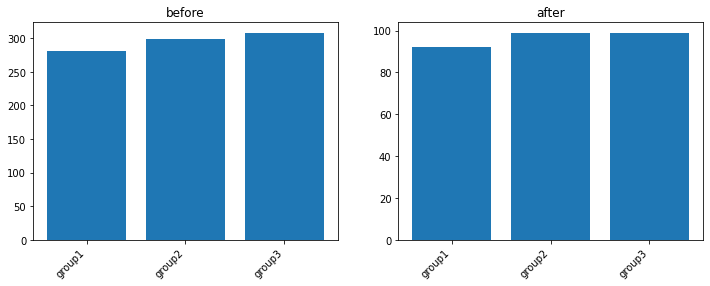


 Column 'race', acceptable change: False, min_relative_ratio_change: -0.5678035982008997


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,race1,284,117,0.320180,0.403448,0.260066
1,race2,232,100,0.261556,0.344828,0.318371
2,race3,276,39,0.311161,0.134483,-0.567804
3,NaN,95,34,0.107103,0.117241,0.094664


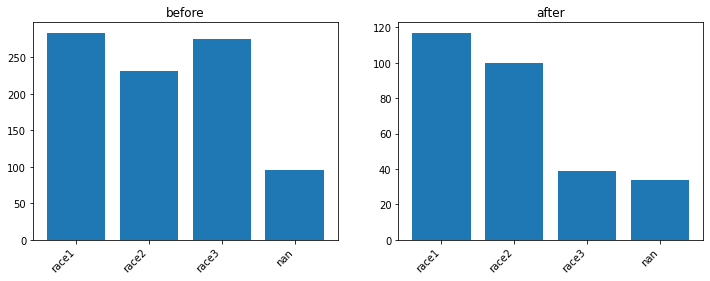

In [4]:
# Select the DagNode we want to look at by index
dag_node, distribution_changes = dag_node_distribution_changes_list[2]

# Investige the changes
print("\033[1m{}: {}\033[0m".format(dag_node.operator_info.operator, dag_node.optional_code_info.source_code))
for column, distribution_change in distribution_changes.items():
    print("")
    print("\033[1m Column '{}'\033[0m, acceptable change: {}, min_relative_ratio_change: {}".format(column, distribution_change.acceptable_change, distribution_change.min_relative_ratio_change))
    display(distribution_change.before_and_after_df)
    NoBiasIntroducedFor.plot_distribution_change_histograms(distribution_change)

# Your answer: Did we find operators that introduce bias? How did the distribution of demographic groups change?

**My anser:** The selection filters out more than 56% of the data points with `race=race3`. The selection is a filter by `county`, so it could be that there is a correlation between `race` and `county` that causes this.